# Loading the Monkbrill2 Datasets
The code just under this shows how to load the monkbrill2 data, once its been split up into training, testing and validation sets (and augmented).

Under this is the code that does this splitting

In [1]:
from data_management.loadDSSCharacters import monkbrillDataset
from data_management.datasetSplitter import datasetSplitter, collate_fn

from torch.utils.data import DataLoader

BATCH_SIZE = 1
shuffle_loaders = True


dataSource = "monkbrill2" # name of the folder, works with "monkbrill" as well

train_folder = "Data/Letters/train/"
val_folder = "Data/Letters/validation/"
test_folder = "Data/Letters/test/"

train_dataset = monkbrillDataset(folder_path=train_folder)
val_dataset = monkbrillDataset(folder_path=val_folder)
test_dataset = monkbrillDataset(folder_path=train_folder)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=shuffle_loaders)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=shuffle_loaders)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=shuffle_loaders)


characterClasses = train_dataset.characterClasses

#train_loader, validation_loader = datasetSplitter(dataset, batch_size=1, validation_split=0.2)

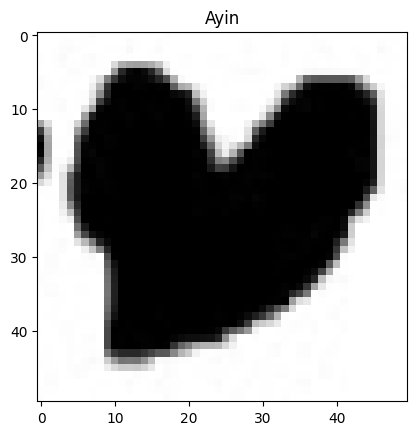

In [12]:
import matplotlib.pyplot as plt

# plot some random character images

imgs, targets = next(iter(train_loader))

plt.imshow(imgs[0].permute(1,2,0), cmap='gray')
plt.title(characterClasses[targets[0]])
plt.show()

## REMOVE DUPLICATE IMAGES FROM ORIGINAL MONKBRILL2 DATASET

In [1]:
import os
from data_management.dssLetters import duplicates_remover, train_test_val_splitter, fillInImbalancedClasses



temp_folder = "Data/dssLettersTemp"
os.makedirs(temp_folder, exist_ok = True)

source_folder = "monkbrill2/"

# ignore images that have x AND y positions that are less different (to any other image from the same DSS) 
# than positionThreshold, AND same for width AND height for sizeThreshold
positionThreshold = 50
sizeThreshold = 5

print("\ncopying non-duplicate images to a temporary folder")
duplicates_remover(source_folder, temp_folder, positionThreshold, sizeThreshold)



######################################################
# make train, test, validation sets

target_folder = "Data/dssLetters"

# make test, train, (validation) set folders into the target_folder
validation_set = True  # whether or not we want a seperate validation set (makes the training set smaller)
reshape = True         # if we want to reshape all of the images now
desired_size = 50      # and to what size (eg. 50 is 50x50)

print("\nmaking train, test, (& validation) folders")
train_test_val_splitter(temp_folder, target_folder, validation_set = validation_set, reshape = True, desired_size = 50)
# also deletes the temp_folder




#############################################
fillClassImbalance = True

if fillClassImbalance:
    # fill in class imbalances using the Habbakuk letters
    training_set_folder = target_folder + "/train"
    fill_amount = 1  # fills in each class with new images until it has the same number as the class with the most images
    # could be less than 1 (e.g. 0.7 to prevent having too many Habbakuk letters relative to the real DSS letters)
    # or more than 1 (e.g. adds habbakuk letters to all classes)

    print("\naddressing class imbalance by generating new images")
    fillInImbalancedClasses(training_set_folder, amount=fill_amount)



copying non-duplicate images to a temporary folder

making train, test, (& validation) folders
train
    Counter({'Lamed': 135, 'He': 127, 'Mem': 125, 'Gimel': 124, 'Alef': 124, 'Nun-medial': 124, 'Ayin': 122, 'Samekh': 122, 'Bet': 122, 'Het': 121, 'Mem-medial': 120, 'Qof': 115, 'Taw': 113, 'Tsadi-medial': 113, 'Tet': 112, 'Shin': 108, 'Kaf': 83, 'Nun-final': 59, 'Waw': 49, 'Dalet': 36, 'Resh': 32, 'Tsadi-final': 30, 'Pe': 15, 'Yod': 9, 'Pe-final': 8, 'Zayin': 6, 'Kaf-final': 4})
test
    Counter({'Lamed': 83, 'He': 78, 'Mem': 77, 'Alef': 77, 'Nun-medial': 76, 'Gimel': 76, 'Bet': 75, 'Samekh': 75, 'Ayin': 74, 'Het': 74, 'Mem-medial': 73, 'Qof': 70, 'Taw': 69, 'Tsadi-medial': 69, 'Tet': 68, 'Shin': 66, 'Kaf': 51, 'Nun-final': 37, 'Waw': 30, 'Dalet': 22, 'Resh': 20, 'Tsadi-final': 19, 'Pe': 9, 'Yod': 5, 'Pe-final': 4, 'Zayin': 3, 'Kaf-final': 3})
validation
    Counter({'Lamed': 58, 'He': 54, 'Mem': 54, 'Alef': 54, 'Bet': 53, 'Nun-medial': 53, 'Gimel': 53, 'Het': 52, 'Samekh': 52, 'Ayin

# Data Augmentation (on the entire training set)

In [26]:
import os 
import cv2
import matplotlib.pyplot as plt
import random
from itertools import chain, combinations
from data_management.augmentation.commonAug import imageRotator, imageShearer, letterImageWarper, imageDilator, imageEroder

training_set_folder = "Data/dssLetters/train_copy"

possible_transforms = ["rotate", "shear", "warp", "erode", "dilate"]

number_of_augmentations = 5   # 5 augmention runs per original image


def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(1, len(ss)+1)))

all_combinations = list(all_subsets(possible_transforms))
print("number of augmentation method combinations:", len(all_combinations))


for folder in os.listdir(training_set_folder):
    counter = 0
    print(folder)

    folderPath = os.path.join(training_set_folder, folder)
    orginalFiles = [os.path.join(folderPath, filename) for filename in os.listdir(folderPath)]

    for orig_img_path in orginalFiles:
        counter += 1
        orig_img = cv2.imread(orig_img_path, cv2.IMREAD_GRAYSCALE)

        # for each possible combination of aug methods
        for subset in random.sample(all_combinations, number_of_augmentations):  
            img = orig_img.copy()

            transformations = list(subset)
            random.shuffle(transformations)
            fileName = folder + "_" + str(counter) + "_"

            
            for transform in transformations:
                #print(transform, transform[0])
                fileName += transform[0]

                if transform == "rotate":
                    img = imageRotator(img, rotation_range=15) # rotate up to 15 degrees either direction
                    imageDilator, imageEroder
                elif transform == "shear":
                    img = imageShearer(img, shear_range=0.15)
                elif transform == "warp":
                    img = letterImageWarper(img)
                elif transform == "erode":
                    img = imageEroder(img, max_erode_size=4)    # erode and dilates with a kernel of a random size in range [2, max_X_size]
                elif transform == "dilate":
                    img = imageDilator(img, max_dilate_size=4)

            
            fileName += ".png"
            target_path = os.path.join(folderPath, fileName)
            
            cv2.imwrite(target_path, img)

print("DONE!")









number of augmentation method combinations: 31
Alef
Ayin
Bet
Dalet
Gimel
He
Het
Kaf
Kaf-final
Lamed
Mem
Mem-medial
Nun-final
Nun-medial
Pe
Pe-final
Qof
Resh
Samekh
Shin
Taw
Tet
Tsadi-final
Tsadi-medial
Waw
Yod
Zayin
